# Libraries

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, hour, weekofyear, dayofweek, days
from pyspark.sql.functions import col, corr
from pyspark.sql.functions import mean, stddev, min, max, count, countDistinct
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from keras import Sequential
from keras.layers import Dense, Input
import pandas as pd
from keras import optimizers

In [2]:
# Create spark session
spark = SparkSession.builder \
    .appName("Statistic analysis") \
    .getOrCreate()

# Load data from csv file
df_yearly_prices_extra = spark.read.csv("../Data/df_yearly_prices_extra.csv", header=True, inferSchema=True)
df_yearly_prices_no_outliers = spark.read.csv("../Data/df_yearly_prices_no_outliers.csv", header=True, inferSchema=True)

# The Neural Network

In [3]:
# Convert spark dataframe to pandas dataframe and drop unnecessary columns

df_yearly_prices_no_outliers =df_yearly_prices_no_outliers.drop("datetime", "percentage", '_c0', 'year')
df_yearly_prices_no_outliers = df_yearly_prices_no_outliers.toPandas()
df_yearly_prices_no_outliers.head()


,value,month,week,day,hour,weekday
0,204.51,1,52,7,0,0
1,171.35,1,52,7,1,0
2,172.70,1,52,7,2,0
3,156.07,1,52,7,3,0
4,159.08,1,52,7,4,0


In [4]:
# stdev and mean por each column
df_yearly_prices_no_outliers.describe()

,value,month,week,day,hour,weekday
count,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000
mean,280.110671,6.528131,26.580273,4.013418,11.498941,0.710099
std,90.697948,3.461948,15.083559,2.010639,6.906847,0.453743
min,39.590000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,223.097500,4.000000,14.000000,2.000000,6.000000,0.000000
50%,281.810000,7.000000,26.000000,4.000000,12.000000,1.000000
75%,340.970000,10.000000,40.000000,6.000000,17.000000,1.000000
max,531.020000,12.000000,52.000000,7.000000,23.000000,1.000000


#### Define features

In [5]:
# Define Features and Labels
y_outliers = df_yearly_prices_no_outliers.value
X_outliers = df_yearly_prices_no_outliers.drop(['value'], axis=1)

#### Initialize Model

In [6]:
from keras import activations
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1)])

#### Calculate predictions before fitting

In [7]:
# predictions before fitting
y_pred_before = model.predict(X_outliers).flatten()

266/266 [==============================] - 1s 2ms/step


#### Compile and fit the model

In [8]:
model.compile(optimizer='rmsprop', loss='mse')
model.fit(X_outliers, y_outliers, epochs=500)

Epoch 1/500
266/266 [==============================] - 1s 1ms/step - loss: 70940.2031
Epoch 2/500
266/266 [==============================] - 0s 1ms/step - loss: 64906.4727
Epoch 3/500
266/266 [==============================] - 0s 1ms/step - loss: 59306.9961
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 54097.7305
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 49301.4219
Epoch 6/500
266/266 [==============================] - 0s 1ms/step - loss: 44923.7695
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 40945.3164
Epoch 8/500
266/266 [==============================] - 0s 1ms/step - loss: 37369.4922
Epoch 9/500
266/266 [==============================] - 0s 1ms/step - loss: 34248.3633
Epoch 10/500
266/266 [==============================] - 0s 1ms/step - loss: 31496.3535
Epoch 11/500
266/266 [==============================] - 0s 973us/step - loss: 29172.0977
Epoch 12/500
266/266 [============================

#### Predictions

In [9]:
y_pred_after = model.predict(X_outliers).flatten()


266/266 [==============================] - 0s 855us/step


In [10]:
# create dataframe with predictions before and after fitting
df_pred_outliers = pd.DataFrame({'y' : y_outliers, 'y_pred_before': y_pred_before, 'y_pred_after': y_pred_after})



In [11]:
df_pred_outliers.head(10)

,y,y_pred_before,y_pred_after
0,204.51,30.151905,99.737907
1,171.35,30.565674,104.792671
2,172.70,30.979446,109.847427
3,156.07,31.393219,114.902191
4,159.08,31.806988,119.956955
5,157.28,32.220760,125.011711
6,158.87,32.634533,130.066467
7,157.58,33.048302,135.121246
8,156.18,33.462074,140.175995
9,118.96,33.875847,145.230759


#### Score

In [12]:
# score model
df_pred_outliers_errors = df_pred_outliers.copy()
df_pred_outliers_errors['error_before'] = df_pred_outliers_errors['y'] - df_pred_outliers_errors['y_pred_before']
df_pred_outliers_errors['error_after'] = df_pred_outliers_errors['y'] - df_pred_outliers_errors['y_pred_after']

In [13]:
df_pred_outliers_errors['error2'] = df_pred_outliers_errors['error_after']**2
df_pred_outliers_errors['error2'] =df_pred_outliers_errors['error2'].mean()
df_pred_outliers_errors = df_pred_outliers_errors.drop([
    'y_pred_before', 'y_pred_after'], axis=1)


In [14]:
df_pred_outliers_errors.head(10)

,y,error_before,error_after,error2
0,204.51,174.358095,104.772093,9084.155379
1,171.35,140.784326,66.557329,9084.155379
2,172.70,141.720554,62.852573,9084.155379
3,156.07,124.676781,41.167809,9084.155379
4,159.08,127.273012,39.123045,9084.155379
5,157.28,125.059240,32.268289,9084.155379
6,158.87,126.235467,28.803533,9084.155379
7,157.58,124.531698,22.458754,9084.155379
8,156.18,122.717926,16.004005,9084.155379
9,118.96,85.084153,-26.270759,9084.155379


In [15]:
model.evaluate(X_outliers, y_outliers)

  1/266 [..............................] - ETA: 32s - loss: 6898.6602

266/266 [==============================] - 0s 1ms/step - loss: 9084.1553


9084.1552734375

# Activate  functions

#### Sigmoid

In [31]:
from keras import activations, optimizers
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1, activation='sigmoid')])
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_outliers, y_outliers, epochs=500)

y_pred_after = model.predict(X_outliers).flatten()

dic_fit_history = {}
dic_fit_history['sigmoid'] = history.history['loss']
df_pred_outliers['pred_sigmoid'] = y_pred_after

Epoch 1/500
266/266 [==============================] - 1s 1ms/step - loss: 86129.5938
Epoch 2/500
266/266 [==============================] - 0s 1ms/step - loss: 86128.0469
Epoch 3/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9766
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9453
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9453
Epoch 6/500
266/266 [==============================] - 0s 2ms/step - loss: 86127.9375
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9219
Epoch 8/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9453
Epoch 9/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9141
Epoch 10/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9062
Epoch 11/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9453
Epoch 12/500
266/266 [==============================

KeyboardInterrupt: 

#### linear

In [17]:
from keras import activations
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1, activation='linear')])
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_outliers, y_outliers, epochs=500)

y_pred_after = model.predict(X_outliers).flatten()
dic_fit_history['linear'] = history.history['loss']
df_pred_outliers['pred_linear'] = y_pred_after

Epoch 1/500
266/266 [==============================] - 1s 1ms/step - loss: 83771.2656
Epoch 2/500
266/266 [==============================] - 0s 1ms/step - loss: 76935.3984
Epoch 3/500
266/266 [==============================] - 0s 1ms/step - loss: 70505.5781
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 64487.1641
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 58863.0430
Epoch 6/500
266/266 [==============================] - 0s 1ms/step - loss: 53684.3711
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 48893.2930
Epoch 8/500
266/266 [==============================] - 0s 992us/step - loss: 44524.5156
Epoch 9/500
266/266 [==============================] - 0s 995us/step - loss: 40558.5820
Epoch 10/500
266/266 [==============================] - 0s 978us/step - loss: 37007.3047
Epoch 11/500
266/266 [==============================] - 0s 977us/step - loss: 33880.9727
Epoch 12/500
266/266 [======================

#### tanh

In [18]:
from keras import activations
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1, activation='tanh')])
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_outliers, y_outliers, epochs=500)

y_pred_after = model.predict(X_outliers).flatten()
dic_fit_history['tanh'] = history.history['loss']
df_pred_outliers['pred_tanh'] = y_pred_after

Epoch 1/500
266/266 [==============================] - 1s 1ms/step - loss: 87199.2734
Epoch 2/500
266/266 [==============================] - 0s 1ms/step - loss: 86940.4531
Epoch 3/500
266/266 [==============================] - 0s 1ms/step - loss: 86293.6875
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 86128.7969
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9297
Epoch 6/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.8984
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9219
Epoch 8/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9297
Epoch 9/500
266/266 [==============================] - 0s 2ms/step - loss: 86127.9062
Epoch 10/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9141
Epoch 11/500
266/266 [==============================] - 0s 1ms/step - loss: 86127.9297
Epoch 12/500
266/266 [==============================

#### relu

In [19]:
from keras import activations
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1, activation='relu')])
model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_outliers, y_outliers, epochs=500)

y_pred_after = model.predict(X_outliers).flatten()

dic_fit_history['relu'] = history.history['loss']
df_pred_outliers['pred_relu'] = y_pred_after

Epoch 1/500


266/266 [==============================] - 1s 1ms/step - loss: 80984.8750
Epoch 2/500
266/266 [==============================] - 0s 973us/step - loss: 74252.0469
Epoch 3/500
266/266 [==============================] - 0s 970us/step - loss: 67961.3750
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 62075.9531
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 56582.8789
Epoch 6/500
266/266 [==============================] - 0s 973us/step - loss: 51540.5156
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 46872.1406
Epoch 8/500
266/266 [==============================] - 0s 1ms/step - loss: 42619.5039
Epoch 9/500
266/266 [==============================] - 0s 1ms/step - loss: 38785.7617
Epoch 10/500
266/266 [==============================] - 0s 1ms/step - loss: 35377.8203
Epoch 11/500
266/266 [==============================] - 0s 1ms/step - loss: 32358.4219
Epoch 12/500
266/266 [==============================] - 0s

In [20]:
df_pred_outliers.head(10)

,y,y_pred_before,y_pred_after,pred_sigmoid,pred_linear,pred_tanh,pred_relu
0,204.51,30.151905,99.737907,1.0,96.984558,1.0,103.770073
1,171.35,30.565674,104.792671,1.0,102.017159,1.0,108.825424
2,172.70,30.979446,109.847427,1.0,107.049751,1.0,113.880775
3,156.07,31.393219,114.902191,1.0,112.082352,1.0,118.936127
4,159.08,31.806988,119.956955,1.0,117.114944,1.0,123.991470
5,157.28,32.220760,125.011711,1.0,122.147545,1.0,129.046829
6,158.87,32.634533,130.066467,1.0,127.180138,1.0,134.102173
7,157.58,33.048302,135.121246,1.0,132.212738,1.0,139.157532
8,156.18,33.462074,140.175995,1.0,137.245331,1.0,144.212875
9,118.96,33.875847,145.230759,1.0,142.277924,1.0,149.268234


In [21]:
%load_ext autoreload
%autoreload 2


In [22]:
%pip install utils

Note: you may need to restart the kernel to use updated packages.


In [23]:
import sys
sys.path.append('..')
import utils

In [24]:
dic_fit_history.keys()

dict_keys(['sigmoid', 'linear', 'tanh', 'relu'])

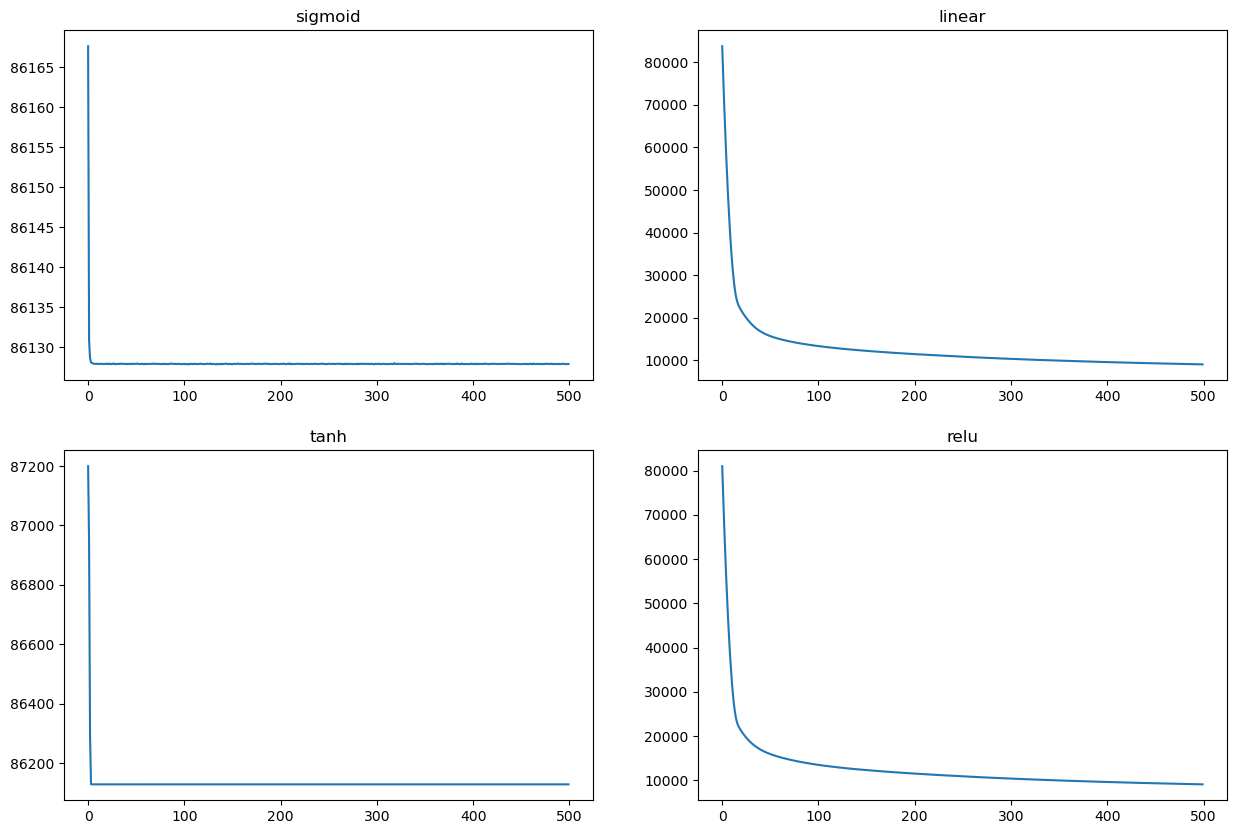

In [28]:
# plot the loss for all activation functions in different plots withou utils
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(dic_fit_history['sigmoid'])
plt.title('sigmoid')
plt.subplot(2, 2, 2)
plt.plot(dic_fit_history['linear'])
plt.title('linear')
plt.subplot(2, 2, 3)
plt.plot(dic_fit_history['tanh'])
plt.title('tanh')
plt.subplot(2, 2, 4)
plt.plot(dic_fit_history['relu'])
plt.title('relu')
plt.show()




In [37]:
from keras import activations, optimizers
model = Sequential(layers=[Input(shape=X_outliers.shape[1]),Dense(units=1, activation='linear')])
model.compile(optimizer = optimizers.Adam(), loss='mse')
history = model.fit(X_outliers, y_outliers, epochs=500)

y_pred_after = model.predict(X_outliers).flatten()

dic_fit_history = {}
dic_fit_history['linear_op_adam'] = history.history['loss']
df_pred_outliers['linar_optimizer_adam'] = y_pred_after

Epoch 1/500
266/266 [==============================] - 1s 1ms/step - loss: 86017.1953
Epoch 2/500
266/266 [==============================] - 0s 1ms/step - loss: 79115.7188
Epoch 3/500
266/266 [==============================] - 0s 1ms/step - loss: 72764.9453
Epoch 4/500
266/266 [==============================] - 0s 1ms/step - loss: 66937.4375
Epoch 5/500
266/266 [==============================] - 0s 1ms/step - loss: 61590.6211
Epoch 6/500
266/266 [==============================] - 0s 1ms/step - loss: 56692.5039
Epoch 7/500
266/266 [==============================] - 0s 1ms/step - loss: 52211.1758
Epoch 8/500
266/266 [==============================] - 0s 1ms/step - loss: 48130.5781
Epoch 9/500
266/266 [==============================] - 0s 1ms/step - loss: 44430.9922
Epoch 10/500
266/266 [==============================] - 0s 1ms/step - loss: 41083.9375
Epoch 11/500
266/266 [==============================] - 0s 1ms/step - loss: 38072.9492
Epoch 12/500
266/266 [==============================

In [38]:
df_pred_outliers.head(10)

,y,y_pred_before,y_pred_after,pred_sigmoid,pred_linear,pred_tanh,pred_relu,pred_sigmoid_op_adam,linar_optimizer_adam
0,204.51,30.151905,99.737907,1.0,96.984558,1.0,103.770073,1.0,98.850975
1,171.35,30.565674,104.792671,1.0,102.017159,1.0,108.825424,1.0,103.892982
2,172.70,30.979446,109.847427,1.0,107.049751,1.0,113.880775,1.0,108.934990
3,156.07,31.393219,114.902191,1.0,112.082352,1.0,118.936127,1.0,113.976997
4,159.08,31.806988,119.956955,1.0,117.114944,1.0,123.991470,1.0,119.019012
5,157.28,32.220760,125.011711,1.0,122.147545,1.0,129.046829,1.0,124.061020
6,158.87,32.634533,130.066467,1.0,127.180138,1.0,134.102173,1.0,129.103027
7,157.58,33.048302,135.121246,1.0,132.212738,1.0,139.157532,1.0,134.145050
8,156.18,33.462074,140.175995,1.0,137.245331,1.0,144.212875,1.0,139.187042
9,118.96,33.875847,145.230759,1.0,142.277924,1.0,149.268234,1.0,144.229065
